In [1]:
from collections import defaultdict
from pathlib import Path
import re

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyprojroot
import seaborn as sns

import tqdm

In [2]:
# specify the custom font to use
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'arial'

In [3]:
re_int = re.compile(r'[0-9]+')

def int_from_dir_path(dir_path):
    name = dir_path.name
    return int(re_int.search(name)[0])

In [4]:
REPO_ROOT = pyprojroot.here()
BR_RESULTS_ROOT = REPO_ROOT.joinpath('results/BirdsongRecognition')

In [5]:
BR_RESULTS_ROOT

PosixPath('/home/art/Documents/repos/coding/birdsong/tweetynet/results/BirdsongRecognition')

In [6]:
BIRDS_ROOTS = sorted(BR_RESULTS_ROOT.glob('Bird*'))

In [7]:
dfs = []

for bird_root in BIRDS_ROOTS:
    if bird_root.name == 'Bird10':
        continue  # didn't run experiment, not enough data for test set of correct duration
    else:
        bird_num = int_from_dir_path(bird_root)
        results_roots = sorted(bird_root.glob('results_*'))
        most_recent_results = results_roots[-1]
        df = pd.read_csv(most_recent_results.joinpath('learning_curve.csv'))
        df['avg_error'] = 1 - df['avg_acc']
        df['bird'] = bird_num
        dfs.append(df)

curve_df = pd.concat(dfs)
# make 'bird' the first column
columns = ['bird', 'train_set_dur', 'replicate_num', 'model_name', 'avg_acc', 'avg_levenshtein', 'avg_loss', 'avg_segment_error_rate', 'avg_error']
curve_df = curve_df[columns]
curve_df['bird'] = curve_df['bird'].astype('category')

curve_df['avg_error'] = curve_df['avg_error'] * 100

# add 'train_set_dur_ind' column that maps train set durations to consecutive integers
# so we can plot with those integers as the xticks, but then change the xticklabels to the actual values
# -- this lets us avoid having the labels overlap when the training set durations are close to each other
# e.g., 30 and 45
train_set_durs = sorted(curve_df['train_set_dur'].unique())
dur_int_map = dict(zip(train_set_durs, range(len(train_set_durs))))
curve_df['train_set_dur_ind'] = curve_df['train_set_dur'].map(dur_int_map)

In [8]:
curve_df.head()

,bird,train_set_dur,replicate_num,model_name,avg_acc,avg_levenshtein,avg_loss,avg_segment_error_rate,avg_error,train_set_dur_ind
0,0,120.0,1,TweetyNet,0.964375,139,0.116330,0.059332,3.562498,3
1,0,120.0,10,TweetyNet,0.973549,97,0.083475,0.042982,2.645141,3
2,0,120.0,2,TweetyNet,0.968502,118,0.105680,0.051192,3.149754,3
3,0,120.0,3,TweetyNet,0.965855,136,0.108927,0.057526,3.414476,3
4,0,120.0,4,TweetyNet,0.967369,124,0.103485,0.053421,3.263074,3


values from Okanoya paper are taken from this table:
[https://doi.org/10.1371/journal.pone.0159188.t001](https://doi.org/10.1371/journal.pone.0159188.t001)

Their call "note error rate" is what we call "segment error rate".
We chose the values from their models that achieved the lowest error rate.

### Figure

In [9]:
TRAIN_DUR_IND_MAP = {
    k:v for k, v in zip(
        sorted(curve_df['train_set_dur'].unique()), 
        sorted(curve_df['train_set_dur_ind'].unique())
    )
}

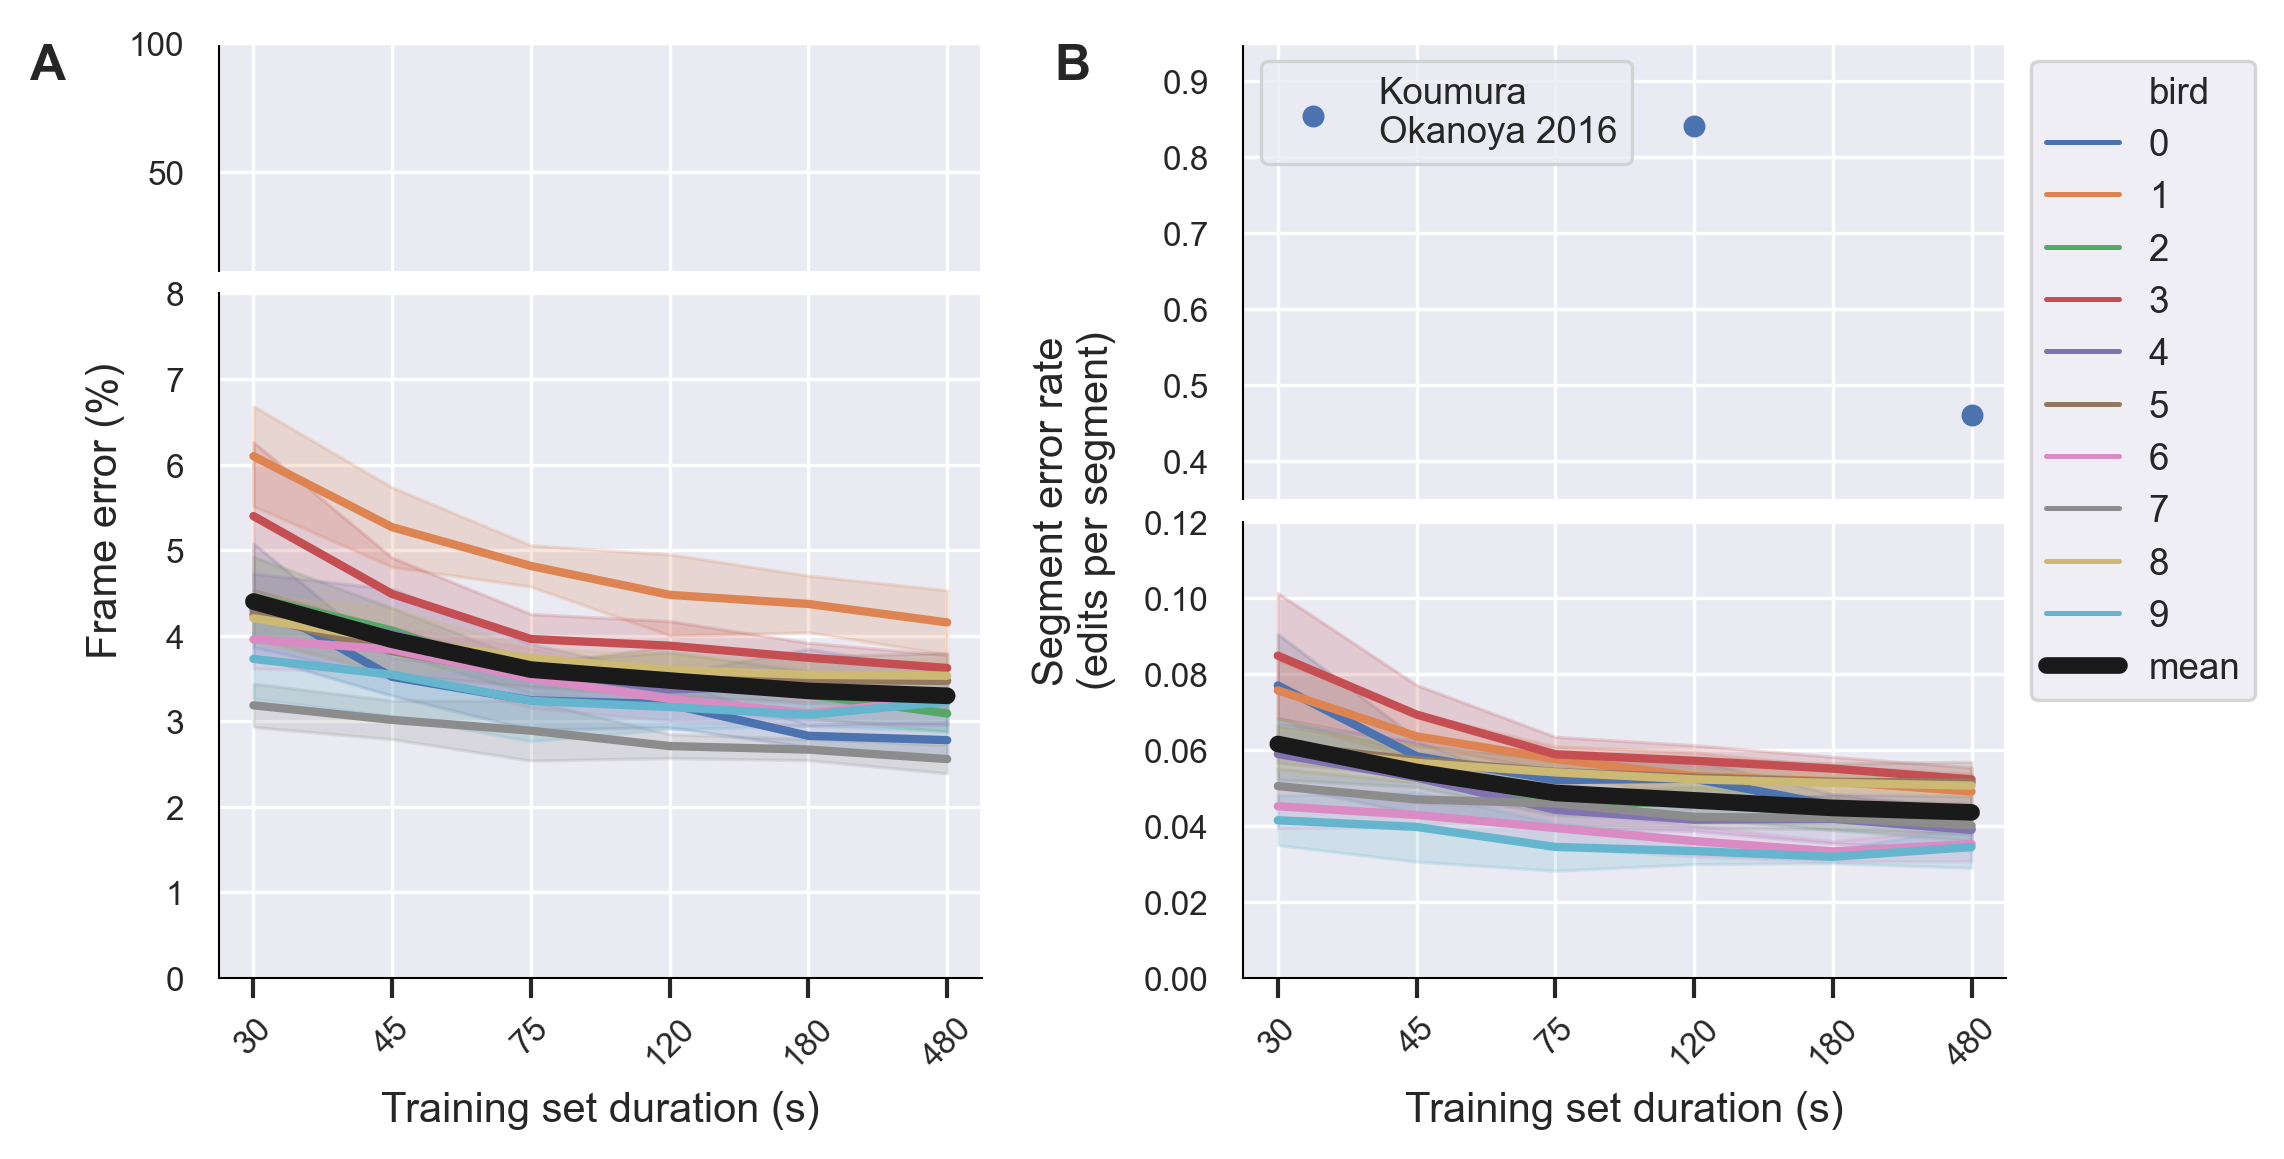

In [10]:
SAVE_FIG = True

sns.set("paper")

KOUMURA_OKANOYA_NOTE_ERROR_RATES = {
    120. : 0.84,
    480. : 0.46,
}
KOUMURA_OKANOYA_X = np.asarray([TRAIN_DUR_IND_MAP[k] for k in KOUMURA_OKANOYA_NOTE_ERROR_RATES.keys()])
KOUMURA_OKANOYA_Y = np.asarray(list(KOUMURA_OKANOYA_NOTE_ERROR_RATES.values()))

# max width in inches is 7.5
# https://journals.plos.org/ploscompbiol/s/figures
FIGSIZE = (7.5, 3.75)
DPI = 300

fig = plt.figure(constrained_layout=True, figsize=FIGSIZE, dpi=DPI)
gs = fig.add_gridspec(nrows=4, ncols=2, hspace=0.005)

ax_arr = []
ax_arr.append(fig.add_subplot(gs[0, 0]))
ax_arr.append(fig.add_subplot(gs[:2, 1]))
ax_arr.append(fig.add_subplot(gs[1:, 0]))
ax_arr.append(fig.add_subplot(gs[2:, 1]))
ax_arr = np.array(ax_arr).reshape(2, 2)
ax_arr[0,0].get_shared_x_axes().join(*ax_arr[:, 0].tolist())
ax_arr[0,0].get_shared_x_axes().join(*ax_arr[:, 1].tolist())

for col in range(2):
    ax_arr[0,col].spines['bottom'].set_visible(False)
    ax_arr[1, col].spines['top'].set_visible(False)
    ax_arr[1, col].xaxis.tick_bottom()
    
metric_list = ['avg_error', 'avg_segment_error_rate']
ylabels = ['Frame error (%)', 'Segment error rate\n(edits per segment)']

for col, (metric, ylabel) in enumerate(zip(metric_list, ylabels)):
    for row in range(2):
        # ax_ind = row * 2 + col
        ax = ax_arr[row, col]
        if row == 1 and col == 1:
            legend = 'full'
        else:
            legend = False
        sns.lineplot(x='train_set_dur_ind', y=metric, hue='bird', data=curve_df, ci='sd', linewidth=2, ax=ax, legend=legend)
        sns.lineplot(x='train_set_dur_ind', y=metric, 
                             linestyle='dashed', color='k', linewidth=4, 
                             data=curve_df, ci=None, label='mean', ax=ax, legend=legend)

        if metric == 'avg_segment_error_rate' and row == 0:
            scatter = ax.scatter(KOUMURA_OKANOYA_X, KOUMURA_OKANOYA_Y, s=20)
            ax.legend(handles=(scatter,), labels=('Koumura\nOkanoya 2016',), loc='upper left')

        ax.set_ylabel('')
        if row == 0:
            ax.set_xticklabels([])
            ax.set_xlabel('')
        elif row == 1:
            ax.set_xlabel('Training set duration (s)', fontsize=10)
            ax.set_xticks(list(dur_int_map.values()))
            ax.set_xticklabels(sorted(curve_df['train_set_dur'].unique().astype(int)), rotation=45)

# zoom-in / limit the view to different portions of the data
ax_arr[0, 0].set_ylim(12, 100)
ax_arr[1, 0].set_ylim(0, 8)
ax_arr[0, 1].set_ylim(0.35, 0.95)
ax_arr[1, 1].set_ylim(0.0, 0.12)        

bigax_col0 = fig.add_subplot(gs[:, 0], frameon=False)
bigax_col1 = fig.add_subplot(gs[:, 1], frameon=False)
labelpads = (2, 10)
panel_labels = ['A', 'B']
for ylabel, labelpad, panel_label, ax in zip(ylabels,
                                             labelpads,
                                             panel_labels,
                                             [bigax_col0, bigax_col1]):
    ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    ax.grid(False)
    ax.set_ylabel(ylabel, fontsize=10, labelpad=labelpad)
    ax.text(-0.2, 1., panel_label, transform=ax.transAxes,
          fontsize=12, fontweight='bold', va='top', ha='right')

# get handles from lower right axes legend, then remove and re-create outside
handles, _ = ax_arr[1, 1].get_legend_handles_labels()
ax_arr[1, 1].get_legend().remove()
bigax_col1.legend(handles=handles, bbox_to_anchor=(1.35, 1))

for row in range(2):
    for col in range(2):
        ax_arr[row, col].spines['left'].set_color('black')
        ax_arr[row, col].spines['left'].set_linewidth(0.5)
        if row == 1:
            ax_arr[row, col].spines['bottom'].set_color('black')
            ax_arr[row, col].spines['bottom'].set_linewidth(0.5)

for ax_ in ax_arr.ravel():
    ax_.tick_params(axis='both', which='major', labelsize=8)
            
fig.set_constrained_layout_pads(hspace=-0.05, wspace=0.0)

if SAVE_FIG:
    plt.savefig(
        REPO_ROOT.joinpath('doc/article/figures/fig4/fig4-learning-curves.png')
    )
    plt.savefig(
        REPO_ROOT.joinpath('doc/article/figures/fig4/fig4-learning-curves.svg')
    )
    plt.savefig(
        REPO_ROOT.joinpath('doc/article/figures/fig4/fig4-learning-curves.tiff')
    )